## TOC
* [Model RDM](#modelrdm-bullet)
* [Plot by model](#plot_mod)
* [Plot by roi](#plot_roi)

In [1]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import os
import numpy as np
import pandas as pd
import scipy.io
from scipy import stats
import scipy.spatial.distance as sp_distance

import nibabel as nib
import nilearn.plotting as plotting
from nilearn.input_data import NiftiMasker, NiftiSpheresMasker

import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.manifold import MDS
from sklearn.preprocessing import normalize
from nltools.mask import create_sphere

# %matplotlib notebook
%matplotlib inline
%autosave 5
sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})

/gpfs/ysm/project/rj299/conda_envs/py37_dev/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Autosaving every 5 seconds


In [16]:
base_root = '/home/rj299/scratch60/mdm_analysis/'
data_root = '/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_rsa_nosmooth/'
out_root = '/home/rj299/scratch60/mdm_analysis/output/'
anat_mean = nib.load(os.path.join(out_root, 'imaging', 'all_sub_average.nii.gz'))

In [3]:
stims = {'01': 'Med_amb_0', '02': 'Med_amb_1', '03': 'Med_amb_2', '04': 'Med_amb_3',
         '05': 'Med_risk_0', '06': 'Med_risk_1', '07': 'Med_risk_2', '08': 'Med_risk_3', 
         '09': 'Mon_amb_0', '10': 'Mon_amb_1', '11': 'Mon_amb_2', '12': 'Mon_amb_3',
         '13': 'Mon_risk_0', '14': 'Mon_risk_1', '15': 'Mon_risk_2', '16': 'Mon_risk_3'}

stim_num = len(stims)

subjects = [2073, 2550, 2582, 2583, 2584, 2585, 2588, 2592, 
            2593, 2594, 2596, 2597, 2598, 2599, 2600, 2624, 
            2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 
            2658, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 2666]

In [46]:
# all rois' names
sub = 2654
roi_rdm_obj = np.load(os.path.join(data_root, 'rdm_new/_subject_id_%s/roi_rdm.npy' %sub),
              allow_pickle = True)
roi_rdm = roi_rdm_obj.item()
roi_names = list(roi_rdm.keys())

print('All names of ROIs:')
for roi_name in roi_names:
    print(roi_name)

All names of ROIs:
vmpfc
vstr
med_mon_1
med_mon_2
med_mon_3
gilaie_rppc
zhang_val_lppc
zhang_val_lofc
zhang_val_rofc
zhang_val_lingual
zhang_sal_acc
zhang_sal_lprecentral
zhang_sal_lcaudate
zhang_sal_rcaudate
zhang_sal_linsula
zhang_sal_rinsula
zhang_sal_lingual
levy_amb_striatum
levy_amb_mpfc
levy_amb_ppc
levy_amb_lamyg
levy_amb_sts
levy_risk_striatum
levy_risk_mpfc


## Model RDM <a class="anchor" id="modelrdm-bullet"></a>

In [60]:
# Load model RDMs in vectors
mod_rdm_vector_obj = np.load(os.path.join(data_root, 'roi_compare_with_model/model_rdms_vector.npy'),
                              allow_pickle = True)

mod_rdm_vector = mod_rdm_vector_obj.item()

mod_rdm_vector.keys()

mod_names = list(mod_rdm_vector.keys())

### Get p values from permutation test

In [49]:
stats_perm = {}

for roi_name in roi_names:

    # load data
    spearman_r = np.load(os.path.join(data_root, 'roi_compare_with_model/spearman_r_with_model_%s.npy' %roi_name),
                         allow_pickle = True).item()


    # load permutation null distribution
    spearman_r_perm = np.load(os.path.join(data_root, 'roi_compare_with_model/perm_null_%s.npy' %roi_name),
                         allow_pickle = True).item()

    mod_names = list(spearman_r.keys())
    # calculate p values for each model

    stats_perm_roi = {}

    for mod_name in mod_names:
        r = spearman_r[mod_name]    
        r_null = spearman_r_perm[mod_name]
        r_null.sort()

        r_median = np.median(r)

        # p value for this model (for the right tail, 1-p)
        p_mod = min(range(len(r_null)), key=lambda i: abs(r_null[i]-r_median))/len(r_null)

        # p values for right tail
        if p_mod > 0.5:
            p_mod = 1-p_mod

        critical_95_up = r_null[int(len(r_null) * (1-0.05/2))]
        critical_95_low = r_null[int(len(r_null) * (0.05/2))]

        stats_perm_roi[mod_name] = [r_median, p_mod, critical_95_low, critical_95_up]
    
    stats_perm[roi_name] = stats_perm_roi
    
# np.save(os.path.join(data_root, 'roi_compare_with_model/perm_stats.npy'), stats_perm)

In [62]:
np.save(os.path.join(data_root, 'roi_compare_with_model/perm_stats.npy'), stats_perm)

In [58]:
# Print all rois
for roi_name in stats_perm.keys():
    print(roi_name)
    
    for mod_name in stats_perm[roi_name].keys():
        print(mod_name, ':', stats_perm[roi_name][mod_name])
        
    print()    

vmpfc
domain : [0.30668855714277504, 0.0004999999999999449, -0.043523958173963026, 0.0313472798772242]
uncertainty : [-0.0265218091868752, 0.43799999999999994, -0.048348941566461634, -0.007595897952947107]
value : [0.0995983793135933, 0.0010000000000000009, 0.04051237483677226, 0.08293161891087877]
sv : [0.12632473912136058, 0.0004999999999999449, -0.0001597913992717197, 0.05691962311424048]
rating : [0.0836100037095247, 0.0004999999999999449, 0.005350483430201236, 0.054845865292144164]

vstr
domain : [0.6620808002469029, 0.0004999999999999449, -0.07137687872871026, 0.028695120113490222]
uncertainty : [-0.03713053286162528, 0.033, -0.038219300315496654, 0.004219685406822491]
value : [-0.035562514464929765, 0.0, 0.012742722308942384, 0.050535345780219634]
sv : [0.13150893184798257, 0.0004999999999999449, -0.012457674495515068, 0.038677603155600954]
rating : [0.07553652788478657, 0.0004999999999999449, 0.0009420316270617882, 0.0450794055752463]

med_mon_1
domain : [0.3660009667788778, 0.

##  Bar plot by Model

In [85]:
roi_names

['vmpfc',
 'vstr',
 'med_mon_1',
 'med_mon_2',
 'med_mon_3',
 'gilaie_rppc',
 'zhang_val_lppc',
 'zhang_val_lofc',
 'zhang_val_rofc',
 'zhang_val_lingual',
 'zhang_sal_acc',
 'zhang_sal_lprecentral',
 'zhang_sal_lcaudate',
 'zhang_sal_rcaudate',
 'zhang_sal_linsula',
 'zhang_sal_rinsula',
 'zhang_sal_lingual',
 'levy_amb_striatum',
 'levy_amb_mpfc',
 'levy_amb_ppc',
 'levy_amb_lamyg',
 'levy_amb_sts',
 'levy_risk_striatum',
 'levy_risk_mpfc']

In [94]:
roi_names_sort = ['vstr',
                  'levy_amb_striatum',
                  'levy_risk_striatum',
                  'zhang_sal_lcaudate',
                  'zhang_sal_rcaudate',
                  'vmpfc',
                  'levy_amb_mpfc',
                  'levy_risk_mpfc',
                  'zhang_sal_acc',
                  'levy_amb_ppc',
                  'zhang_val_lofc',
                  'zhang_val_rofc',
                  'gilaie_rppc',
                  'zhang_val_lppc',
                  'med_mon_1',
                  'med_mon_2',
                  'med_mon_3',
                  'zhang_sal_linsula',
                  'zhang_sal_rinsula',
                  'levy_amb_lamyg',
                  'levy_amb_sts',
                  'zhang_sal_lprecentral',
                  'zhang_val_lingual',                 
                  'zhang_sal_lingual',
                 ]

roi_names_sort_leg = ['vstr',
                  'levy_amb_striatum',
                  'levy_risk_striatum',
                  'zhang_sal_lcaudate',
                  'zhang_sal_rcaudate',
                  'vmpfc',
                  'levy_amb_mpfc',
                  'levy_risk_mpfc',
                  'zhang_sal_acc',
                  'levy_amb_pcc',
                  'zhang_val_lofc',
                  'zhang_val_rofc',
                  'gilaie_rppc',
                  'zhang_val_lppc',
                  'med_mon_1',
                  'med_mon_2',
                  'med_mon_3',
                  'zhang_sal_linsula',
                  'zhang_sal_rinsula',
                  'levy_amb_lamyg',
                  'levy_amb_sts',
                  'zhang_sal_lprecentral',
                  'zhang_val_lingual',                 
                  'zhang_sal_lingual',
                 ]

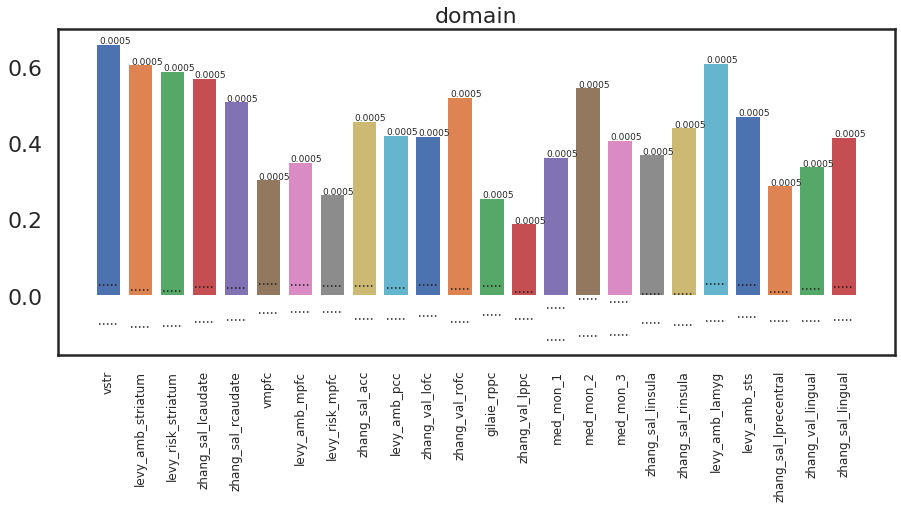

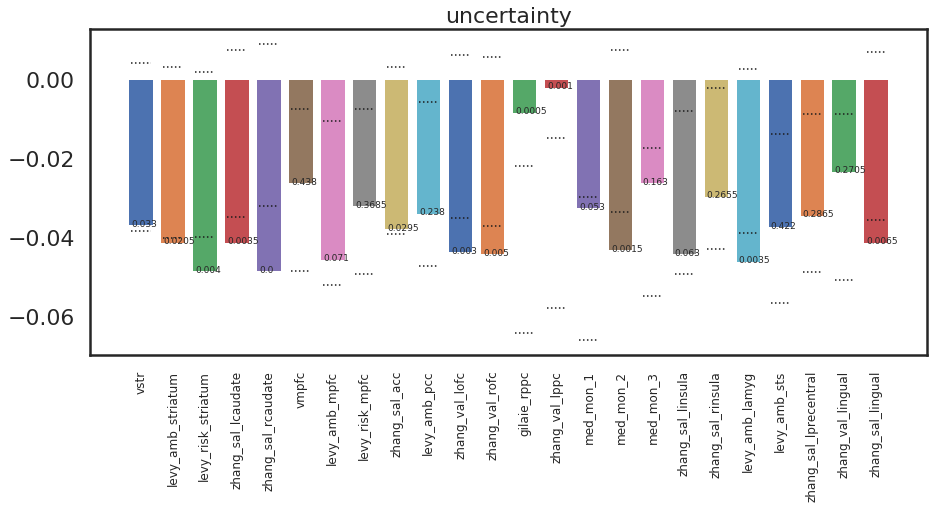

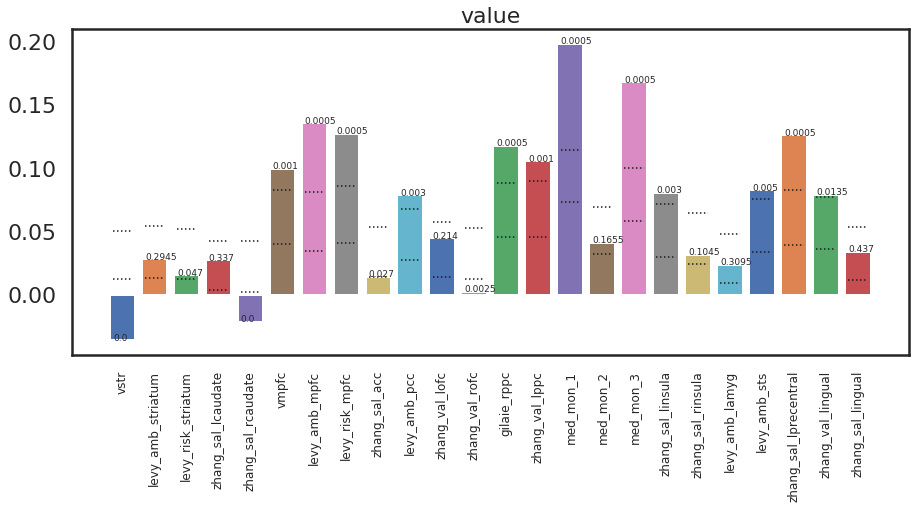

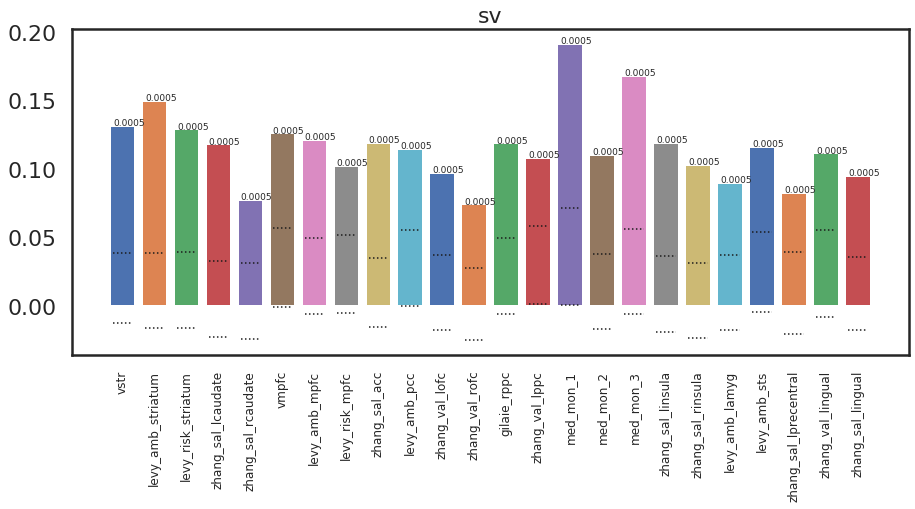

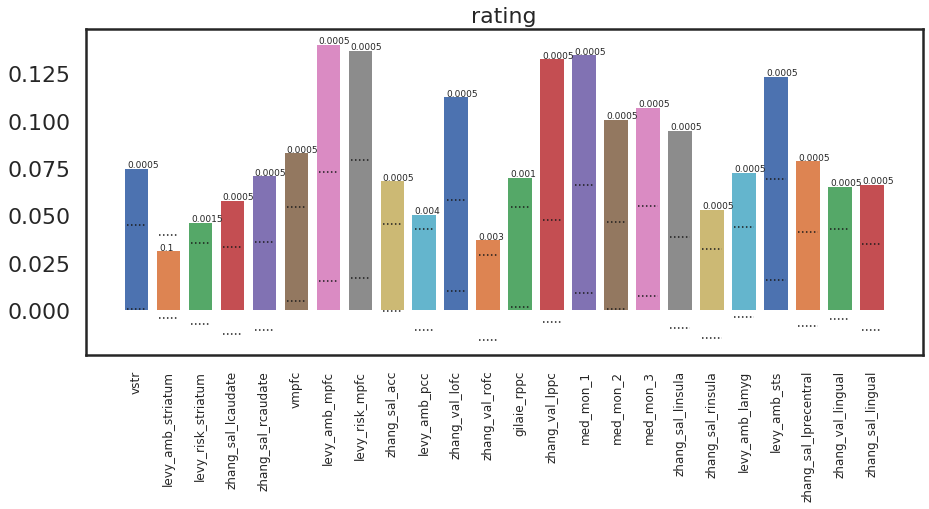

In [127]:
# stats_perm = np.load(os.path.join(data_root, 'roi_compare_with_model/perm_stats.npy'), 
#                      allow_pickle = True).item()

# plot each model
for mod_name in mod_names:
    fig, ax = plt.subplots(1,1, figsize = (15, 6))
    
    # length will be the number of ROIs
    r_plot = []
    eb_low = []
    eb_up = []
    p = []
    
    for roi_idx, roi_name in enumerate(roi_names_sort):
#         r_plot.append(stats_perm[roi_name][mod_name][0])
#         eb_low.append(stats_perm[roi_name][mod_name][2])
#         eb_up.append(stats_perm[roi_name][mod_name][3])
#         p.append(stats_perm[roi_name][mod_name][1])

        r_plot = (stats_perm[roi_name][mod_name][0])
        eb_low = (stats_perm[roi_name][mod_name][2])
        eb_up = (stats_perm[roi_name][mod_name][3])
        p = (stats_perm[roi_name][mod_name][1])

        ax.bar(roi_idx, r_plot) # for different color
        ax.hlines(eb_up, xmin = roi_idx-0.3, xmax = roi_idx+0.3, linestyle = 'dotted', linewidth = 1.5)
        ax.hlines(eb_low, xmin = roi_idx-0.3, xmax = roi_idx+0.3, linestyle = 'dotted', linewidth = 1.5)
        ax.annotate(round(p, 4), (roi_idx-0.3, r_plot), fontsize = 9)
        
    ax.set_xticks(list(range(len(roi_names_sort))))
    ax.set_xticklabels(roi_names_sort_leg, fontsize = 12, rotation = 90)

#     ax.legend(roi_names_sort_leg, fontsize = 9, loc = 'right', bbox_to_anchor=(1.2, .5))
    ax.set_title(mod_name, fontsize = 22)    

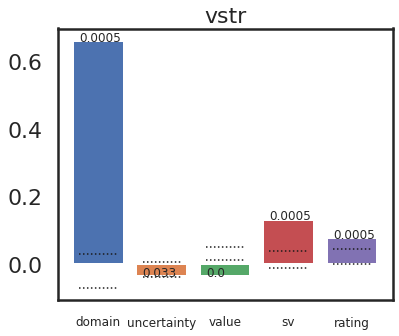

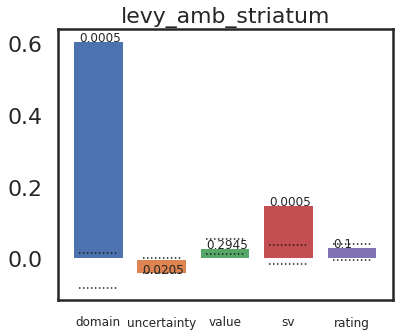

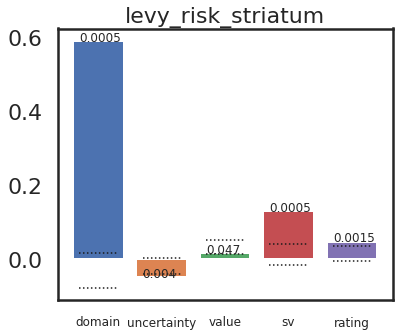

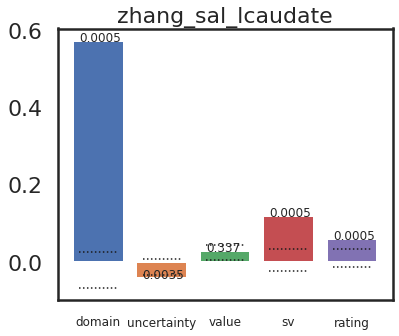

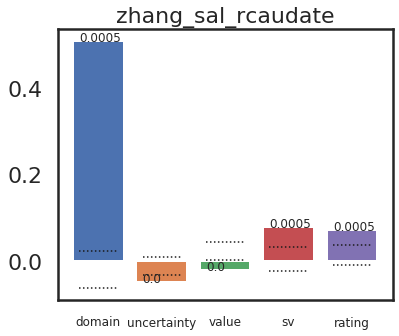

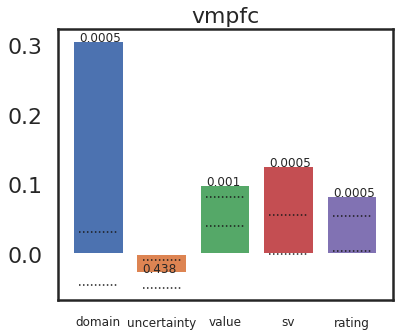

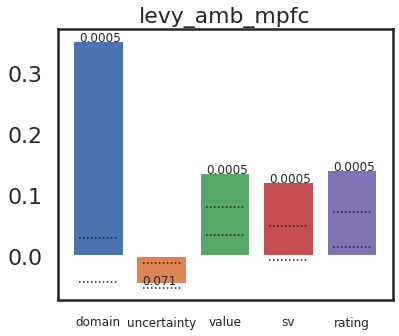

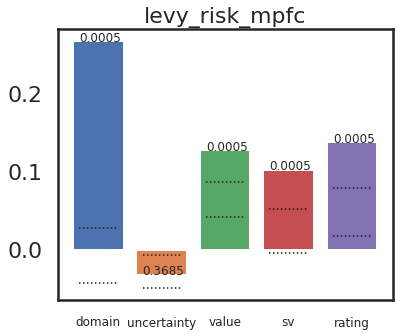

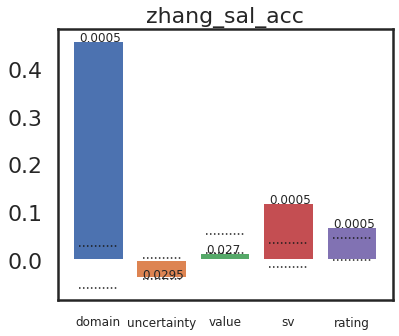

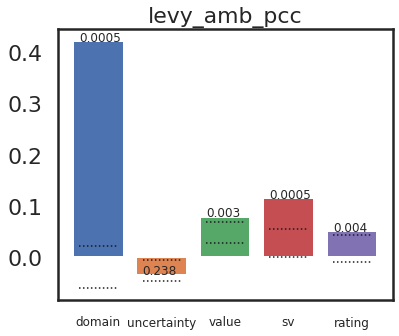

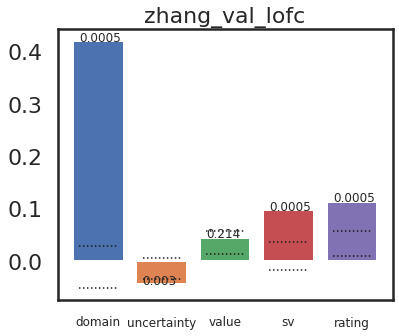

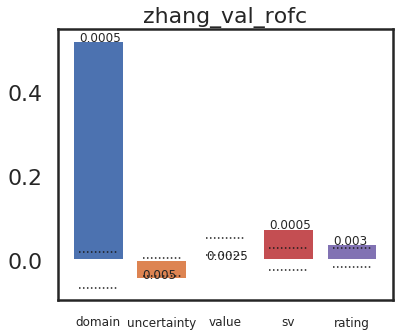

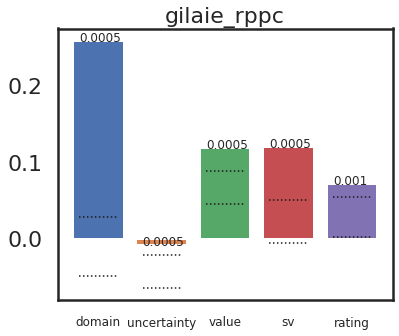

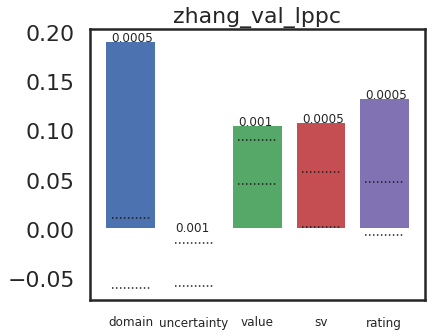

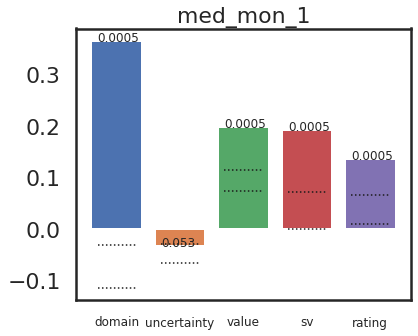

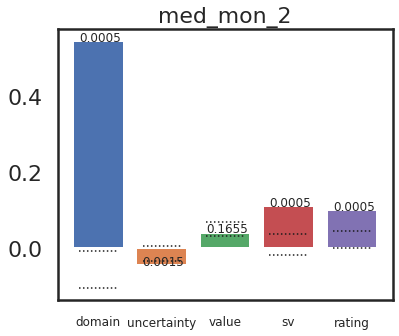

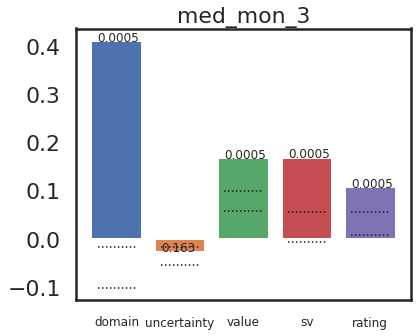

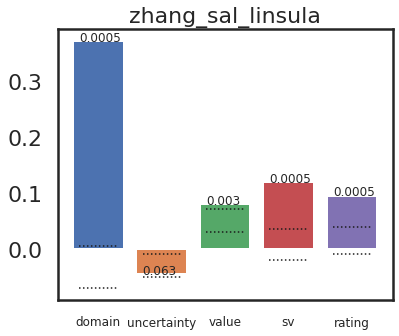

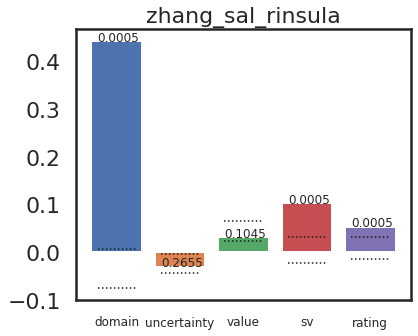

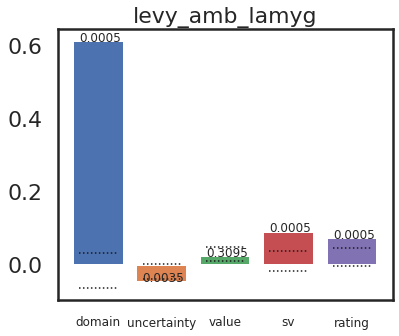

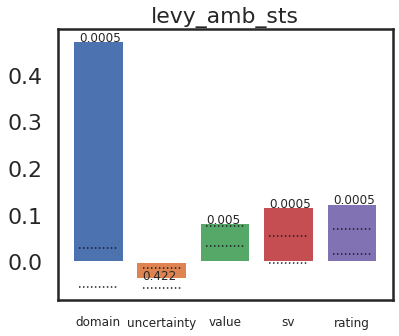

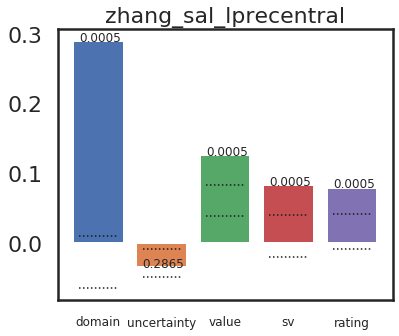

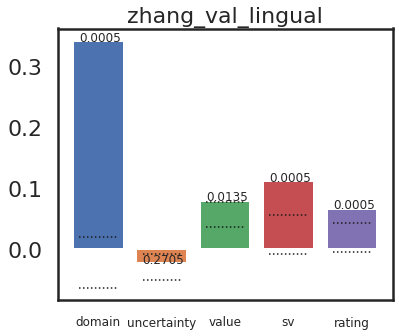

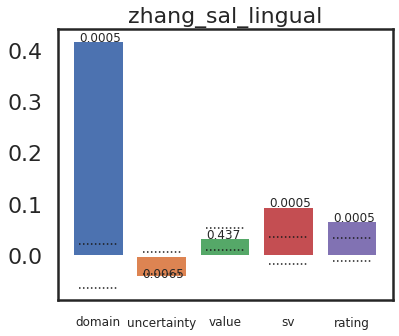

In [129]:
# stats_perm = np.load(os.path.join(data_root, 'roi_compare_with_model/perm_stats.npy'), 
#                      allow_pickle = True).item()

# plot each model
for roi_name in roi_names_sort:
    fig, ax = plt.subplots(1,1, figsize = (6, 5))
    
    # length will be the number of ROIs
    r_plot = []
    eb_low = []
    eb_up = []
    p = []
    
    for mod_idx, mod_name in enumerate(mod_names):
#         r_plot.append(stats_perm[roi_name][mod_name][0])
#         eb_low.append(stats_perm[roi_name][mod_name][2])
#         eb_up.append(stats_perm[roi_name][mod_name][3])
#         p.append(stats_perm[roi_name][mod_name][1])

        r_plot = (stats_perm[roi_name][mod_name][0])
        eb_low = (stats_perm[roi_name][mod_name][2])
        eb_up = (stats_perm[roi_name][mod_name][3])
        p = (stats_perm[roi_name][mod_name][1])

        ax.bar(mod_idx, r_plot) # for different color
        ax.hlines(eb_up, xmin = mod_idx-0.3, xmax = mod_idx+0.3, linestyle = 'dotted', linewidth = 1.5)
        ax.hlines(eb_low, xmin = mod_idx-0.3, xmax = mod_idx+0.3, linestyle = 'dotted', linewidth = 1.5)
        ax.annotate(round(p, 4), (mod_idx-0.3, r_plot), fontsize = 12)
        
    ax.set_xticks(list(range(len(mod_names))))
    ax.set_xticklabels(mod_names, fontsize = 12, rotation = 0)

#     ax.legend(roi_names_sort_leg, fontsize = 9, loc = 'right', bbox_to_anchor=(1.2, .5))
    if roi_name == 'levy_amb_ppc':
        roi_name = 'levy_amb_pcc'
    ax.set_title(roi_name, fontsize = 22)   